In [1]:
import numpy as np
import pandas as pd
import mokapot

from imspy.timstof.dda import TimsDatasetDDA
from imspy.chemistry.mobility import one_over_k0_to_ccs

from sagepy.utility import create_sage_database
from sagepy.rescore.utility import transform_psm_to_mokapot_pin
from sagepy.core import Precursor, RawSpectrum, ProcessedSpectrum, SpectrumProcessor, Tolerance, Scorer, Representation

from imspy.timstof.dbsearch.utility import sanitize_mz, sanitize_charge, get_searchable_spec
from imspy.algorithm.rescoring import create_feature_space, re_score_psms

def group_by_mobility(mobility, intensity):
    r_dict = {}

    for mob, i in zip(mobility, intensity):
        if mob in r_dict:
            r_dict[mob] += i
        else:
            r_dict[mob] = i

    return np.array(list(r_dict.keys())), np.array(list(r_dict.values()))

# If you do not have timsTOF DDA data available, download this file from proteomexchange: PXD043026, M210115_001_Slot1-1_1_850.d.rar
ds_name = 'M210115_001_Slot1-1_1_850'
dataset = TimsDatasetDDA("/media/hd02/data/raw/dda/ccs/Raw_Yeast_LysN/20190301_TIMS2_FlMe_SA_200ng_Yeast_LysN_IRT_Fraction_16_H8_01_4252.d/")

# read the PASEF fragments into RAM
fragments = dataset.get_pasef_fragments(num_threads=16)

# accumulate re-fragmented frames, since PASEF re-fragments ions below a certain intensity thershold
fragments = fragments.groupby('precursor_id').agg({
    'frame_id': 'first',
    'time': 'first',
    'precursor_id': 'first', 
    'raw_data': 'sum',
    'scan_begin': 'first',
    'scan_end': 'first',
    'isolation_mz': 'first',
    'isolation_width': 'first',
    'collision_energy': 'first',
    'largest_peak_mz': 'first',
    'average_mz': 'first',
    'monoisotopic_mz': 'first',
    'charge': 'first',
    'average_scan': 'first',
    'intensity': 'first',
    'parent_id': 'first',
})

# this data lacks summarized ion-mobility information (point estimate), which can be extracted and added to the df
mobility = fragments.apply(lambda r: r.raw_data.get_inverse_mobility_along_scan_marginal(), axis=1)
fragments['mobility'] = mobility

# also, add a spectrum id for processing of spectra with 
spec_id = fragments.apply(lambda r: str(r['frame_id']) + '-' + str(r['precursor_id']) + '-' + ds_name, axis=1)
fragments['spec_id'] = spec_id

fragments["gaussian_fit"] = fragments.raw_data.apply(lambda r: r.get_mobility_mean_and_variance())

def sanatize_charge(charge):
    try:
        return int(charge)
    except:
        return 2

ccs_mean = fragments.apply(
    lambda r: one_over_k0_to_ccs(r.gaussian_fit[0], r.monoisotopic_mz, sanatize_charge(r.charge)), axis=1
)

ccs_std = fragments.apply(
    lambda r: one_over_k0_to_ccs(r.gaussian_fit[1], r.monoisotopic_mz, sanatize_charge(r.charge)), axis=1
)

fragments["ccs_mean"] = ccs_mean
fragments["ccs_std"] = ccs_std

# create a precursor object
sage_precursor = fragments.apply(lambda r: Precursor(
    mz=sanitize_mz(r['monoisotopic_mz'], r['largest_peak_mz']), 
    intensity=r['intensity'],
    charge=sanitize_charge(r['charge']),
    isolation_window=Tolerance(da=(-3, 3)),
    collision_energy=r.collision_energy,
    inverse_ion_mobility=r.mobility,
), axis=1)

# add the precursor object to the df
fragments['sage_precursor'] = sage_precursor

# create a searchable fragment spectrum, which is a combination of the precursor info and fragment spectrum
processed_spec = fragments.apply(
    lambda r: get_searchable_spec(
        precursor=r.sage_precursor,
        raw_fragment_data=r.raw_data,
        spec_processor=SpectrumProcessor(take_top_n=150),
        spec_id=r.spec_id,
        time=r['time'],
    ),
    axis=1
)

# add the spectra to the data frame
fragments['processed_spec'] = processed_spec

# read a reference fasta file of a proteome, in this case human proteome since this tutorial used HeLa data
path = '/media/hd02/data/fasta/yeast/yeast_proteome.fasta'

cleave_at = "K"
restrict = "U"
c_terminal = False

# Static modifications
static_modifications = {
    "C": "[UNIMOD:4]",
}

# Variable mods need to take a list
variable_modifications = {
    "M": ["[UNIMOD:35]"],
    "[": ["[UNIMOD:1]"]
}

indexed_db = create_sage_database(
    fasta_path=path,
    cleave_at=cleave_at,
    restrict=restrict,
    static_mods=static_modifications,
    variable_mods=variable_modifications,
    c_terminal=c_terminal
)

# create a scorer object that can be used to search a database given a collection of spectra to search
scorer = Scorer(
    precursor_tolerance=Tolerance(ppm=(-25.0, 25.0)),
    fragment_tolerance=Tolerance(ppm=(-20.0, 20.0)),
    report_psms=5,
    min_matched_peaks=5,
    annotate_matches=True,
    static_mods=static_modifications,
    variable_mods=variable_modifications,
)

from sagepy.utility import psm_collection_to_pandas

# scoring the results
psm_collection = scorer.score_collection_psm(
    db=indexed_db, 
    spectrum_collection=fragments['processed_spec'].values,  
    num_threads=16,
)

psm_list = []

for _, values in psm_collection.items():
    psm_list.extend(values)

psm_list = create_feature_space(
    psms=psm_list,
)

psm_list_rescored = re_score_psms(
    psm_list
)

PSM_pandas = psm_collection_to_pandas(psm_list_rescored)

# create a PIN file from the PSMs
PSM_pin = transform_psm_to_mokapot_pin(PSM_pandas)
PSM_pin.to_csv("PSMs.pin", index=False, sep="\t")

psms_moka = mokapot.read_pin("PSMs.pin")
results, models = mokapot.brew(psms_moka)

dest_dir = ""

results.to_txt(dest_dir=dest_dir)

moka_peptides = pd.read_table("mokapot.psms.txt")
moka_peptides = moka_peptides[(moka_peptides["mokapot q-value"] <= 0.01)]
moka_peptides = moka_peptides[(moka_peptides["mokapot PEP"] <= 0.01)]

PSM_pandas = PSM_pandas[PSM_pandas["rank"] == 1]
results_filtered = pd.merge(PSM_pandas, moka_peptides, right_on=["SpecId"], left_on=["spec_idx"])

B = pd.merge(fragments, results_filtered, left_on="spec_id", right_on="spec_idx")
I = B.apply(lambda r: group_by_mobility(r.raw_data.mobility, r.raw_data.intensity), axis=1)

inv_mob, intensity = [x[0] for x in I], [x[1] for x in I]

B["inverse_ion_mobility"] = inv_mob
B["intenisty"] = intensity

IONS_OUT = B[["frame_id", 
   "time",
   "ims",
   "expmass",
   "calcmass",
   "collision_energy_x",
   "collision_energy_calibrated",
   "spectral_angle_similarity",
   "scan_begin", 
   "scan_end", 
   "largest_peak_mz", 
   "average_mz", 
   "monoisotopic_mz", 
   "sequence", 
   "sequence_modified",
   "ccs_mean",
   "ccs_std",
   "charge_x",
   "hyperscore",
   "re_score",
   "mokapot q-value",
   "spectrum_q",
   "peptide_q",
   "protein_q",
   "inverse_ion_mobility",
   "intenisty"
  ]].rename(columns={"charge_x": "charge", "collision_energy_x": "collision_energy"})

IONS_OUT.to_parquet(f"{ds_name}.parquet", index=False)

2024-12-08 13:32:28.572944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 13:32:28.573015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 13:32:28.603315: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 13:32:28.680482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-08 13:32:29.533763: W tensorflow/compiler/tf2

TypeError: create_feature_space() got an unexpected keyword argument 'psm_list'

In [2]:
import pandas as pd

In [7]:
T = pd.read_parquet("/media/hd02/data/raw/dda/ccs/Raw_Yeast_LysC/20190304_tims03_FlMe_SA_200ng_Yeast_Lysc_IRT_Fraction_14_F5_1_1514.d/imspy_ccs/20190304_tims03_FlMe_SA_200ng_Yeast_Lysc_IRT_Fraction_14_F5_1_1514.d.parquet")

In [11]:
def process_mq_sequence(seq):
    seq = seq.replace("(ox)", "[UNIMOD:35]")
    seq = seq.replace("(ac)", "[UNIMOD:1]")
    seq = seq.replace("C", "C[UNIMOD:4]")
    return seq[1:-1]

mq = pd.read_table("/media/hd02/data/raw/dda/ccs/yeast_results/evidence.txt")
mq["sequence"] = mq["Modified sequence"].apply(lambda s: process_mq_sequence(s))
mq_sub = mq[mq["Raw file"].apply(lambda s: s.find("20190304_tims03_FlMe_SA_200ng_Yeast_Lysc_IRT_Fraction_14_F5_1_1514") != -1)]
mq_sub = mq_sub[mq_sub.Charge > 1]

/tmp/ipykernel_438450/3827414375.py:7: DtypeWarning: Columns (62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  mq = pd.read_table("/media/hd02/data/raw/dda/ccs/yeast_results/evidence.txt")


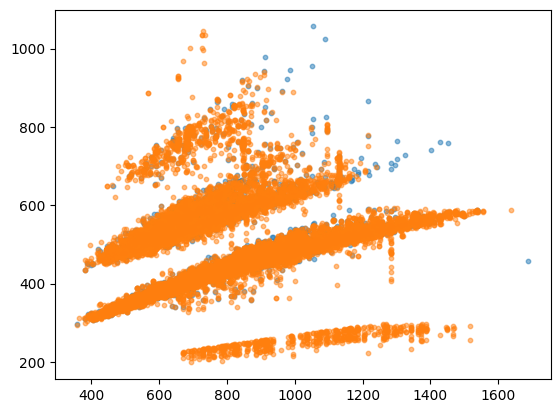

In [12]:
import numpy as np
from matplotlib import pyplot as plt

plt.scatter(mq_sub["m/z"], mq_sub.CCS, alpha=.5, s=10)
plt.scatter(T["monoisotopic_mz"], T.ccs_mean, alpha=.5, s=10)
plt.show()

In [13]:
B = pd.merge(mq_sub, T, left_on=["sequence", "Charge"], right_on=["sequence_modified", "charge"])

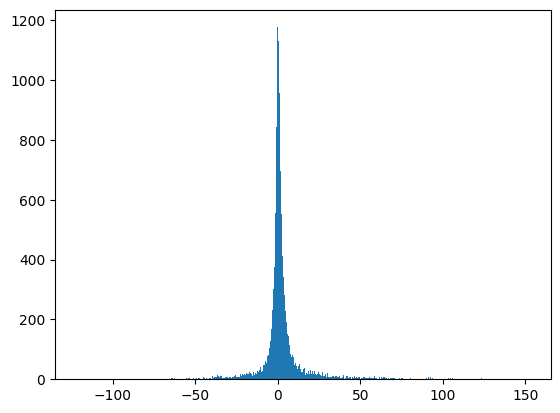

In [14]:
plt.hist(B.CCS - B.ccs_mean, bins="auto")
plt.show()

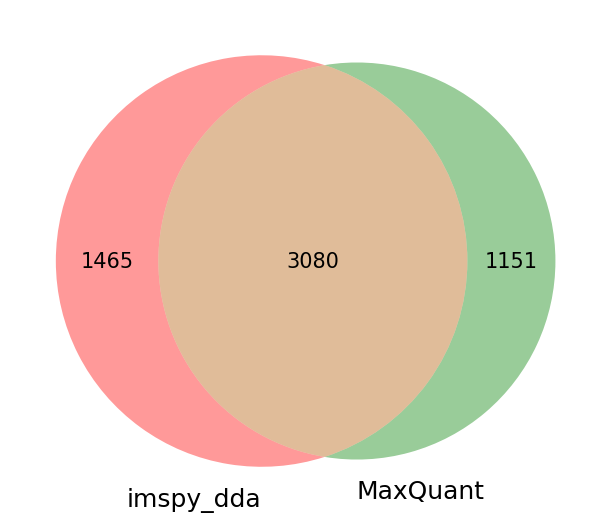

In [16]:
from matplotlib_venn import venn2

plt.figure(figsize=(5, 6), dpi=150)

venn2([set(T[T["mokapot PEP"] <= 0.01].sequence_modified), set(mq_sub.sequence)], ("imspy_dda", "MaxQuant"))
plt.show()

In [21]:
from imspy.algorithm.ccs.predictors import get_model_path, DeepPeptideIonMobilityApex

model = DeepPeptideIonMobilityApex(
    model=get_model_path(),
    model_name="ionmob"
)

T[T["mokapot PEP"] <= 0.01].sequence_modified

TypeError: get_model_path() missing 1 required positional argument: 'model_name'

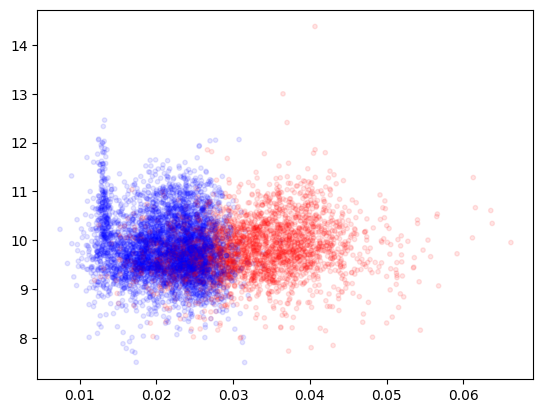

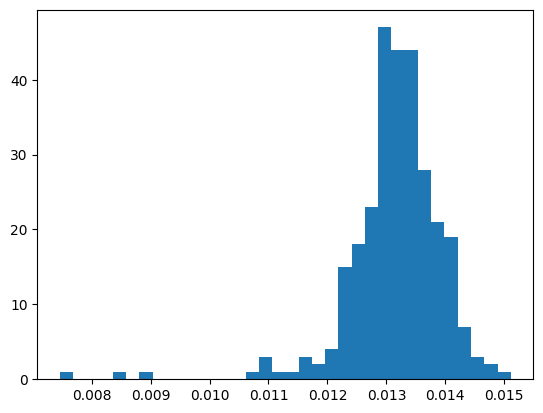

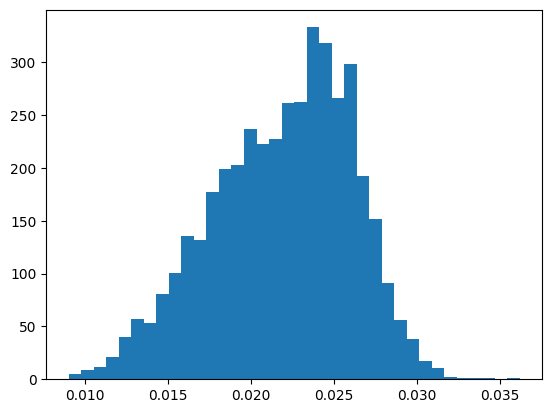

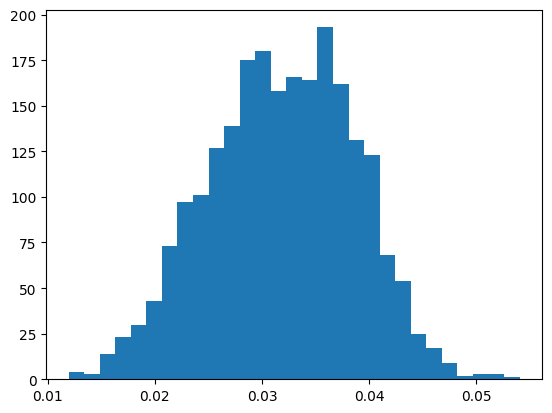

In [130]:


plt.scatter(T.ccs_std, T.intenisty.apply(lambda s: np.log1p(np.sum(s))), s=10, alpha=.1, color = ["blue" if c < 3 else "red" for c in T.charge])
plt.show()

plt.hist(T[T.charge == 1].ccs_std, bins="auto")
plt.show()

plt.hist(T[T.charge == 2].ccs_std, bins="auto")
plt.show()

plt.hist(T[T.charge == 3].ccs_std, bins="auto")
plt.show()

In [131]:
import os
import subprocess

path = "/media/hd02/data/raw/dda/ccs/Raw_Yeast_LysC/"

for folder in os.listdir(path):
    # Construct the full dataset path
    dataset_path = os.path.join(path, folder)
    fasta_path = "/media/hd02/data/fasta/yeast/yeast_proteome.fasta"
    
    # Run the command
    command = ["imspy_ccs", dataset_path, fasta_path, "--c_terminal"]
    try:
        subprocess.run(command, check=True)  # check=True raises an error if the command fails
        print(f"Successfully processed: {folder}")
    except subprocess.CalledProcessError as e:
        print(f"Error processing {folder}: {e}")

2024-12-09 15:36:12.780965: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 15:36:12.780999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 15:36:12.782418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 15:36:12.788662: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 15:36:13.879484: W tensorflow/compiler/tf2